#MonReader

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

Data Description:
The dataset was collected from page flipping video from smart phones and they was labelled as flipping and not flipping. The videos were clipped as short videos and was labelled as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

Goal(s):
Predict if the page is being flipped using a single image.

Data Exploration
Splitting data into train, test and valid
Data preprocessing
Modelling part
Results comparision
Conclusion

In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=162aec629699bb4a990dc6dfda4b4e70250c28cdc22fae75d8ab8910ded32f4b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=dd93411395e73ebc7c9c53526faf0d5a72785b7182372b8c29e7318c7d6eb51c
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [3]:
import warnings
warnings.filterwarnings('ignore')
import shutil
from tqdm.notebook import tqdm
from __future__ import print_function, division
import pandas as pd
from torchsummary import  summary
from termcolor import colored
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import *
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets
import json
import requests
import os
import time
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
#grad cam
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
import random
seed=random.randint(1000,9999)
print(seed)

7163


In [5]:
# Set the random seed for both numpy and pytorch
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
#set device as cuda if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device,"==> is used")

cpu ==> is used


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1- Data exploration

In [8]:
# Get training and testing dataset
train_flip_dir="/content/drive/My Drive/images/training/flip/"
train_flip = os.listdir(train_flip_dir)

train_notflip_dir ="/content/drive/MyDrive/images/training/notflip/"
train_notflip = os.listdir(train_notflip_dir)

test_flip_dir= "/content/drive/MyDrive/images/testing/flip/"
test_flip = os.listdir(test_flip_dir)

test_notflip_dir = "/content/drive/MyDrive/images/testing/notflip/"
test_notflip = os.listdir(test_notflip_dir)

In [9]:
#See the shape of each data folder
print('total training fliped images:', len(train_flip))
print('total training not fliped images:', len(train_notflip))
print('total testing fliped images:', len(test_flip))
print('total testing not fliped images:', len(test_notflip))

total training fliped images: 1062
total training not fliped images: 1100
total testing fliped images: 290
total testing not fliped images: 307


Define the smaller dimension in our image dataset

In [10]:
# define empty lists to store shapes
height_list=[]
width_list=[]

In [11]:
for l in [test_flip_dir,train_flip_dir, train_notflip_dir, test_notflip_dir]:
    liste=os.listdir(l)
    for i in liste:
        filename = os.path.join(l,i)
        img = Image.open(filename)
        height_list.append(img.size[1])
        width_list.append(img.size[0])

In [12]:
#use smaller portion of data
print("the min width in the images data is:", min(width_list))
print("the min height in the images data is:", min(width_list))

the min width in the images data is: 1080
the min height in the images data is: 1080


In [13]:
#set the minimum size as a base for further cropping
base_size=(1080,1080)

In [14]:
#take a test image example
test_img=test_flip_dir+test_flip[0]
img = Image.open(test_img)
img.size

(1080, 1920)

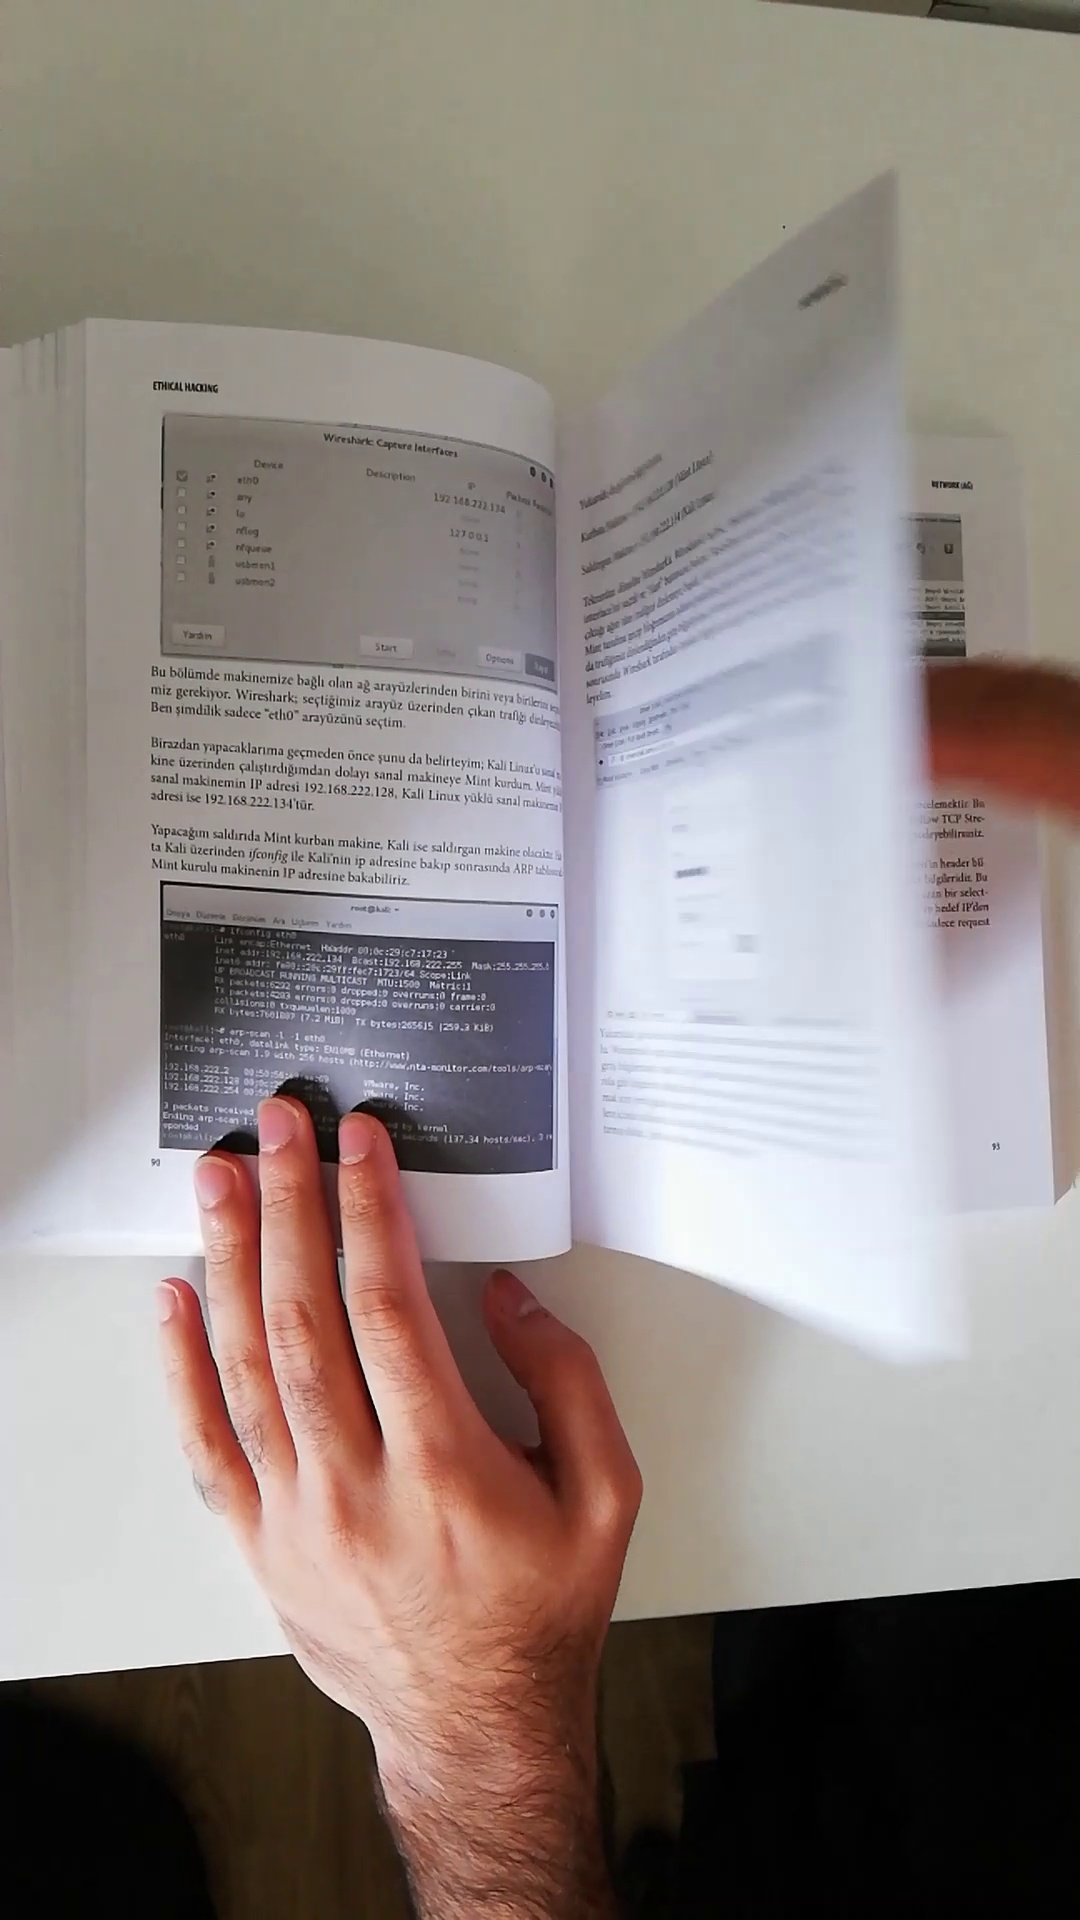

In [15]:
#see the original image
img

As we can see, the dimensions of images are different, so we should unify it for all the dataset as 1080*1080. I will do this in the preprocessing section.

#2. Split training data into train/ valid

In [16]:
X_noflip = np.array(train_notflip)
X_flip = np.array(train_flip)

#set 0 as flip and 1 as notflip
Y_noflip = np.ones(X_noflip.shape[0])
Y_flip = np.zeros(X_flip.shape[0])

X = np.concatenate((X_noflip,X_flip))
Y = np.concatenate((Y_noflip, Y_flip))

print(X.shape)
print(Y.shape)

(2162,)
(2162,)


In [17]:
# Let's take 10% for the validation dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y , test_size = 0.1, random_state = seed)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((1945,), (217,), (1945,), (217,))

So, there is 217 images in the validation dataset and 1945 in training dataset

In [18]:
#Run once
'''os.mkdir('/content/drive/MyDrive/images/valid')
valid_flip_dir='/content/drive/MyDrive/images/valid/flip'
valid_notflip_dir='/content/drive/MyDrive/images/valid/notflip'
os.mkdir(valid_flip_dir)
os.mkdir(valid_notflip_dir)

for i,j in zip(X_val,Y_val):
    if j ==0:# 0 --> flip
      shutil.move(train_flip_dir+i,valid_flip_dir)
    else:
      shutil.move(train_notflip_dir+i,valid_notflip_dir)'''

"os.mkdir('/content/drive/MyDrive/images/valid')\nvalid_flip_dir='/content/drive/MyDrive/images/valid/flip'\nvalid_notflip_dir='/content/drive/MyDrive/images/valid/notflip'\nos.mkdir(valid_flip_dir)\nos.mkdir(valid_notflip_dir)\n\nfor i,j in zip(X_val,Y_val):\n    if j ==0:# 0 --> flip\n      shutil.move(train_flip_dir+i,valid_flip_dir)\n    else:\n      shutil.move(train_notflip_dir+i,valid_notflip_dir)"

In [18]:
#check size of folders
valid_flip_dir='/content/drive/MyDrive/images/valid/flip'
valid_notflip_dir='/content/drive/MyDrive/images/valid/notflip'
print(f'there are {len(os.listdir(valid_flip_dir))} images in the flip validation dataset')
print(f'there are {len(os.listdir(valid_notflip_dir))} images in the notflip validation dataset')
print('--------------> total valid is:',len(os.listdir(valid_flip_dir))+len(os.listdir(valid_notflip_dir)))

there are 111 images in the flip validation dataset
there are 130 images in the notflip validation dataset
--------------> total valid is: 241


#3- Data preprocessing
In this step, I will prepare the dataset for the modeling part, by applying transformers including data augmentation. I should notice that the preprocessing depends on the model I'll use.

Crope images to 1080*1080.\
Resize all images to have size (224, 224) as well as convert them to tensor.\
The ToTensor operation convert all tensors to lie between (0, 1).

In [19]:
#CNN transformer
CNN_transforms = {
    "training": transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
}

After initilizing the trasnformers, let's move to the next step, which is defining datasets. Thus, I'll use 2 main functions: ImageFolder() and Dataloader. ImageFolder saves the images and their respective labels according to the folders they’re present in, and the dataloader divides the data into different batches for training.

In [20]:
data_dir = "/content/drive/MyDrive/images/"

In [21]:
CNN_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          CNN_transforms[x])
                  for x in ['training', 'valid']}

CNN_train_loader = DataLoader(dataset=CNN_datasets['training'], shuffle=True, batch_size=8)
CNN_val_loader = DataLoader(dataset=CNN_datasets['valid'], shuffle=True, batch_size=1)

Let's visualize the distribution of training and testing datasets

In [22]:
CNN_datasets['valid'].class_to_idx
idx2class = {v: k for k, v in CNN_datasets['valid'].class_to_idx.items()}
idx2class

{0: 'flip', 1: 'notflip'}

number of samples in flip class: 1062
number of samples in notflip class: 1100


Text(0.5, 1.0, 'Distribution of training dataset')

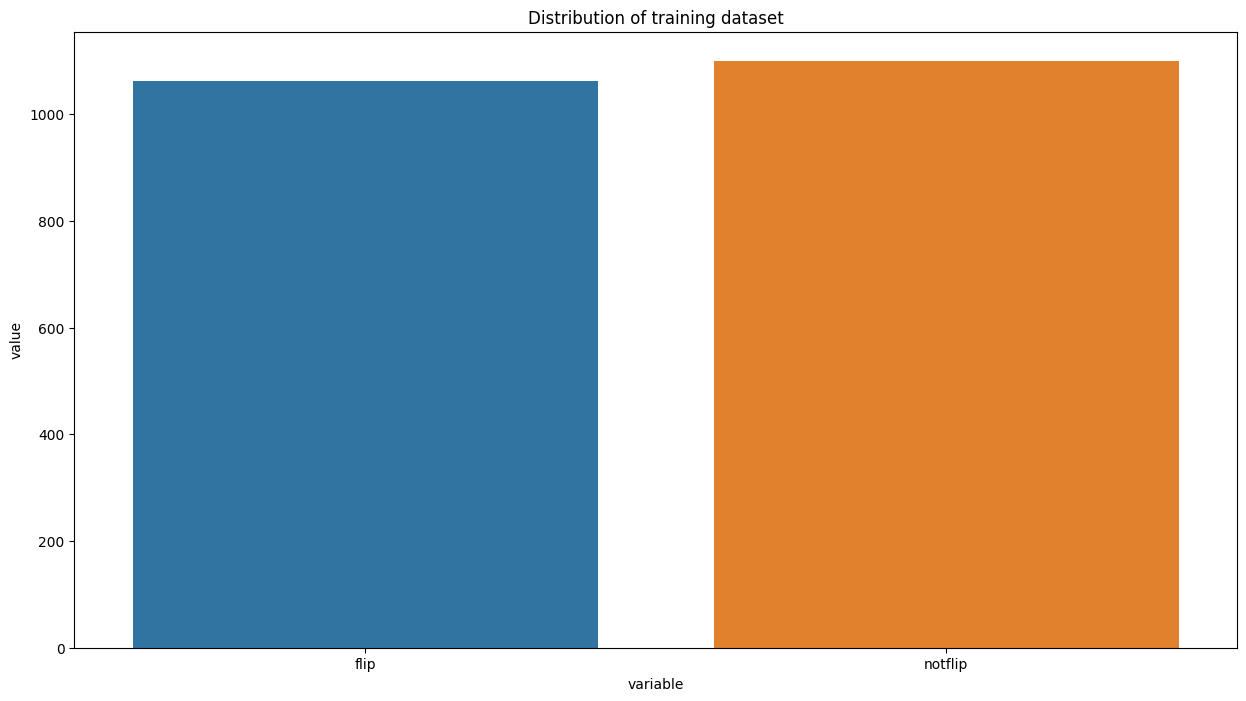

In [ ]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    print("number of samples in flip class:", count_dict['flip'])
    print("number of samples in notflip class:", count_dict['notflip'])
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(CNN_datasets['training']), plot_title="Distribution of training dataset")

number of samples in flip class: 111
number of samples in notflip class: 130


Text(0.5, 1.0, 'Distribution of validation dataset')

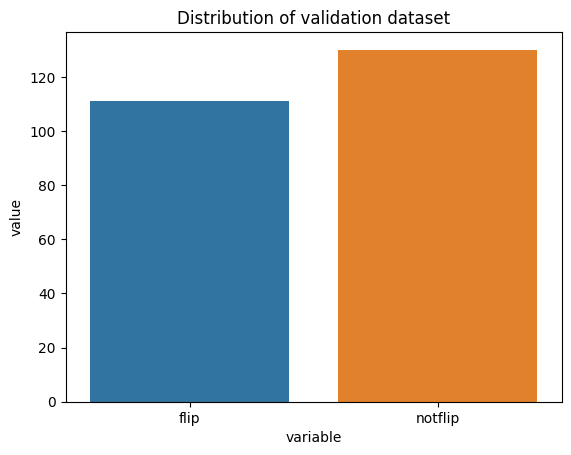

In [ ]:
plot_from_dict(get_class_distribution(CNN_datasets['valid']), plot_title="Distribution of validation dataset")

From the plots above, we can infer the dataset is quite balanced

Before moving to the modeling part, it will be great if we visualise images from dataloaders by batch as followed.

In [23]:
inputs, classes = next(iter(CNN_train_loader))

single_batch is a list of 2 elements. The first element contains the image tensors while the second element contains the output labels.

In [24]:
#get size of the image tensor
inputs.shape
#(batch, channels, height, width)

torch.Size([8, 3, 224, 224])

In [25]:
#Here are the output labels for the batch.
print("Output label tensors: ", classes)
print("\nOutput label tensor shape: ", classes.shape)

Output label tensors:  tensor([1, 0, 0, 0, 0, 1, 0, 0])

Output label tensor shape:  torch.Size([8])


In [26]:
# Selecting the first image tensor from the batch.
single_image = inputs[5]
single_image.shape

torch.Size([3, 224, 224])

In [27]:
#get class names
dataset_sizes = {x: len(CNN_datasets[x]) for x in ['training', 'valid']}
class_names = CNN_datasets['training'].classes
class_names

['flip', 'notflip']

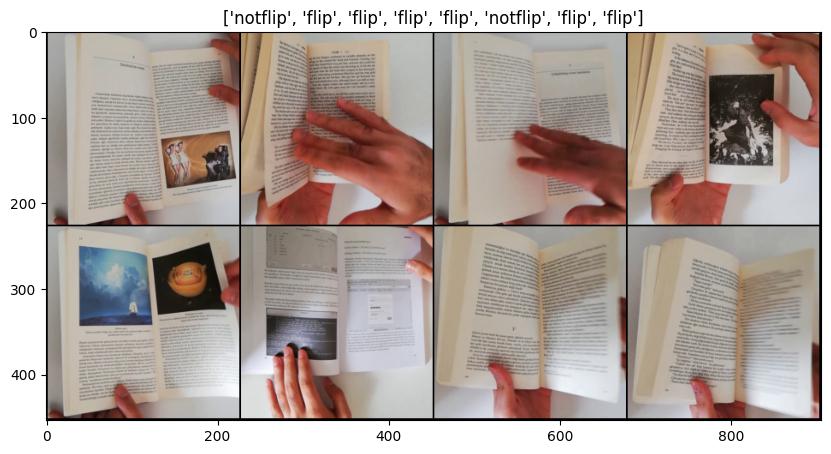

In [28]:
# We do single_batch[0] because each batch is a list
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(inputs, nrow=4)#  nrow: Number of images displayed in each row of the grid.
plt.figure(figsize = (10,10))
plt.title([class_names[x] for x in classes])
plt.imshow(single_batch_grid.permute(1, 2, 0),)

#4. Modeling part
I use 4 blocks of Conv layers. Each block consists of Convolution + BatchNorm + ReLU + Dropout layers.

In [29]:
class flipClassifier(nn.Module):
    def __init__(self):
        super(flipClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [30]:
CNN_model = flipClassifier()
CNN_model.to(device)
print(CNN_model)
criterion = nn.CrossEntropyLoss()#
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)

flipClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [31]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [32]:
#define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.
accuracy_stats_CNN = {
    'train': [],
    "val": []
}
loss_stats_CNN = {
    'train': [],
    "val": []
}

In [33]:
from torch.utils.data import random_split
# Get the total length of the training dataset
train_len = len(CNN_datasets['training'])

# Calculate 10% of the training data
train_subset_len = int(0.1 * train_len)
remaining_len = train_len - train_subset_len

# Randomly split the training dataset into 10% and 90%
train_subset, _ = random_split(CNN_datasets['training'], [train_subset_len, remaining_len])

# Create a DataLoader for the 10% subset
CNN_train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=8)


In [34]:
print("Begin training.")
for e in tqdm(range(1, 7)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    CNN_model.train()
    for X_train_batch, y_train_batch in CNN_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = CNN_model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # Logging training stats
    loss_stats_CNN['train'].append(train_epoch_loss/len(CNN_train_loader))
    accuracy_stats_CNN['train'].append(train_epoch_acc/len(CNN_train_loader))

    # Print training results for the epoch
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(CNN_train_loader):.5f} | Train Acc: {train_epoch_acc/len(CNN_train_loader):.3f}')


Begin training.


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 21.82123 | Train Acc: 63.481
Epoch 02: | Train Loss: 5.67625 | Train Acc: 81.593
Epoch 03: | Train Loss: 3.19313 | Train Acc: 87.630
Epoch 04: | Train Loss: 4.59296 | Train Acc: 83.444
Epoch 05: | Train Loss: 6.26264 | Train Acc: 83.370
Epoch 06: | Train Loss: 3.65725 | Train Acc: 90.407


In [36]:
#save the model
torch.save(CNN_model.state_dict(), "/content/drive/MyDrive/cnn_model.ckpt")

In [37]:
print("Model's state_dict:")
for param_tensor in CNN_model.state_dict():
    print(param_tensor, "\t", CNN_model.state_dict()[param_tensor].size())

Model's state_dict:
block1.0.weight 	 torch.Size([256, 3, 5, 5])
block1.0.bias 	 torch.Size([256])
block1.1.weight 	 torch.Size([256])
block1.1.bias 	 torch.Size([256])
block1.1.running_mean 	 torch.Size([256])
block1.1.running_var 	 torch.Size([256])
block1.1.num_batches_tracked 	 torch.Size([])
block2.0.weight 	 torch.Size([128, 256, 3, 3])
block2.0.bias 	 torch.Size([128])
block2.1.weight 	 torch.Size([128])
block2.1.bias 	 torch.Size([128])
block2.1.running_mean 	 torch.Size([128])
block2.1.running_var 	 torch.Size([128])
block2.1.num_batches_tracked 	 torch.Size([])
block3.0.weight 	 torch.Size([64, 128, 3, 3])
block3.0.bias 	 torch.Size([64])
block3.1.weight 	 torch.Size([64])
block3.1.bias 	 torch.Size([64])
block3.1.running_mean 	 torch.Size([64])
block3.1.running_var 	 torch.Size([64])
block3.1.num_batches_tracked 	 torch.Size([])
lastcnn.weight 	 torch.Size([2, 64, 56, 56])
lastcnn.bias 	 torch.Size([2])


#B. Testing phase

The function below returns the accuracy of the test set as well as 2 lists to calculate further the confusion matrix

In [38]:

def valid_batch_loop(model_test,validloader):

        valid_loss = 0.0
        valid_acc = 0.0
        final_y_pred_list=[]
        final_y_true_list=[]
        for images,labels in tqdm(validloader):

            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            logits = model_test(images)
            acc,y_pred_list,y_true_list=binary_acc_test(logits,labels)
            final_y_pred_list.extend(y_pred_list)
            final_y_true_list.extend(y_true_list)
            valid_acc = valid_acc + acc

        return valid_acc / len(validloader),final_y_pred_list,final_y_true_list

In [39]:
#This function calculate the accuracy and 2 lists, one of predictions and the other for true labels for each input.
def binary_acc_test(y_pred, y_test):
    y_pred_list=[]
    y_true_list=[]
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    y_pred_list.append(y_pred_tags.cpu().numpy())
    y_true_list.append(y_test.cpu().numpy())
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc,y_pred_list,y_true_list

In [40]:
#define test dataset and test dataloader
CNN_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/testing/', transform=CNN_transforms['valid'])
CNN_test_loader = DataLoader(dataset=CNN_test_dataset, shuffle=True, batch_size=1, num_workers=4)

In [43]:
#load the best model to our device
cnn_model = flipClassifier().to(device)
cnn_model.load_state_dict(torch.load('/content/drive/MyDrive/cnn_model.ckpt'))

<All keys matched successfully>

In [44]:
#define the eval mode
cnn_model.eval()
#Check the test accuracy
avg_test_acc_cnn,final_y_pred_list_cnn,final_y_true_list_cnn = valid_batch_loop(cnn_model,CNN_test_loader)
print("Test Acc cnn: {}".format(avg_test_acc_cnn))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Acc cnn: 70.5192642211914


In [45]:
print(classification_report([i[0] for i in final_y_true_list_cnn], [i[0][0][0] for i in final_y_pred_list_cnn],digits=4))

              precision    recall  f1-score   support

           0     0.6397    0.9000    0.7479       290
           1     0.8466    0.5212    0.6452       307

    accuracy                         0.7052       597
   macro avg     0.7431    0.7106    0.6965       597
weighted avg     0.7461    0.7052    0.6950       597

